Capability Test

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits, plot_to_pdf
from utilities_widgets import widget_selector, widget_int_entry
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
sigma_selector = widget_int_entry(value=6, description="Sigma value (1/2 to each tail) selected")
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_filtered_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1), layout=Layout(width='600px'), options=('VA_007_fixture_da…

Table *VA_007_measurements_2024y_01m_09d_18h_15m_58s* retrieved succesfully.
Table *VA_007_limits_2024y_01m_09d_18h_15m_58s* retrieved succesfully.


In [4]:
##Working dataframe creation
MEAS_format = rename_index(MEAS); LIMITS_format = rename_index(LIMITS)
DATA = pd.concat([MEAS, LIMITS], axis=1)
DATA.columns = [f"Test: {i}" for i in range(1, DATA.shape[1]-1)] + ["LSL", "USL"]
DATA_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
DATA_format.columns = [f"Test: {i}" for i in range(1, DATA_format.shape[1]-1)] + ["LSL", "USL"]
display(DATA_format)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,Test: 11,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3287,0.3277,0.3281,0.3286,0.3322,0.3337,0.3225,0.3259,0.3255,0.3256,0.3254,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3511,0.3500,0.3505,0.3510,0.3536,0.3546,0.3457,0.3480,0.3477,0.3482,0.3476,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3298,0.3285,0.3287,0.3293,0.3349,0.3356,0.3239,0.3260,0.3257,0.3264,0.3255,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3521,0.3510,0.3512,0.3515,0.3558,0.3562,0.3462,0.3481,0.3479,0.3482,0.3477,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3245,0.3237,0.3239,0.3247,0.3271,0.3274,0.3213,0.3218,0.3217,0.3225,0.3216,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.3464,0.3453,0.3456,0.3463,0.3481,0.3483,0.3429,0.3433,0.3433,0.3439,0.3431,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.3429,0.3261,0.3301,0.3353,0.3276,0.3286,0.3274,0.3275,0.3273,0.3274,0.3259,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3639,0.3499,0.3532,0.3571,0.3506,0.3515,0.3505,0.3505,0.3504,0.3504,0.3494,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3474,0.3269,0.3306,0.3371,0.3269,0.3283,0.3267,0.3267,0.3270,0.3271,0.3248,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3666,0.3497,0.3537,0.3585,0.3497,0.3510,0.3498,0.3500,0.3500,0.3500,0.3487,0.325,0.358


In [5]:
##Calculation of the specification values
display(means_calculation)
if means_calculation.value == 'Global means':
    specification_means = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    specification_means = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
resume = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns
fiber_values = resume[['mean', 'std']]
fiber_values = fiber_values.rename(columns={'mean': 'fiber mean'})
specification_limits = DATA.iloc[:, -2:]
specification_limits = specification_limits.rename(columns={49: "LSL", 50: "USL"})
specifications = pd.concat([specification_means, fiber_values, specification_limits], axis=1)
specifications_format = rename_index(specifications)
display(specifications_format)

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean,fiber mean,std,LSL,USL
Guia_Luz_Blanco_FB1_X,0.328032,0.327627,0.003209,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.350183,0.349818,0.002702,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.328032,0.328573,0.003773,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.350183,0.350536,0.003302,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.328032,0.323655,0.002148,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.350183,0.345136,0.001985,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.328032,0.329645,0.005098,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.350183,0.352491,0.004352,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.328032,0.329955,0.006647,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.350183,0.352518,0.005428,0.325,0.358


In [6]:
##Calculation of the capability values
display(sigma_selector)
analysis = capability_calculation(specifications, sigma_selector.value)
analysis_format = rename_index(analysis)
display(analysis_format)

IntText(value=6, description='Sigma value (1/2 to each tail) selected')

,mean,fiber mean,std,LSL,USL,CAL_LO_LIMIT,CAL_HI_LIMIT,Cp,Cpk
Guia_Luz_Blanco_FB1_X,0.328032,0.327627,0.003209,0.310,0.335,0.3180,0.3373,1.298400,0.765820
Guia_Luz_Blanco_FB1_Y,0.350183,0.349818,0.002702,0.325,0.358,0.3417,0.3579,2.035692,1.009434
Guia_Luz_Blanco_FB2_X,0.328032,0.328573,0.003773,0.310,0.335,0.3173,0.3399,1.104390,0.567857
Guia_Luz_Blanco_FB2_Y,0.350183,0.350536,0.003302,0.325,0.358,0.3406,0.3604,1.665860,0.753538
Guia_Luz_Blanco_FB3_X,0.328032,0.323655,0.002148,0.310,0.335,0.3172,0.3301,1.940036,1.760848
Guia_Luz_Blanco_FB3_Y,0.350183,0.345136,0.001985,0.325,0.358,0.3392,0.3511,2.770668,2.160053
Guia_Luz_Blanco_FB4_X,0.328032,0.329645,0.005098,0.310,0.335,0.3144,0.3449,0.817265,0.350087
Guia_Luz_Blanco_FB4_Y,0.350183,0.352491,0.004352,0.325,0.358,0.3394,0.3655,1.263753,0.421947
Guia_Luz_Blanco_FB5_X,0.328032,0.329955,0.006647,0.310,0.335,0.3100,0.3499,0.626834,0.253013
Guia_Luz_Blanco_FB5_Y,0.350183,0.352518,0.005428,0.325,0.358,0.3362,0.3688,1.013222,0.336624


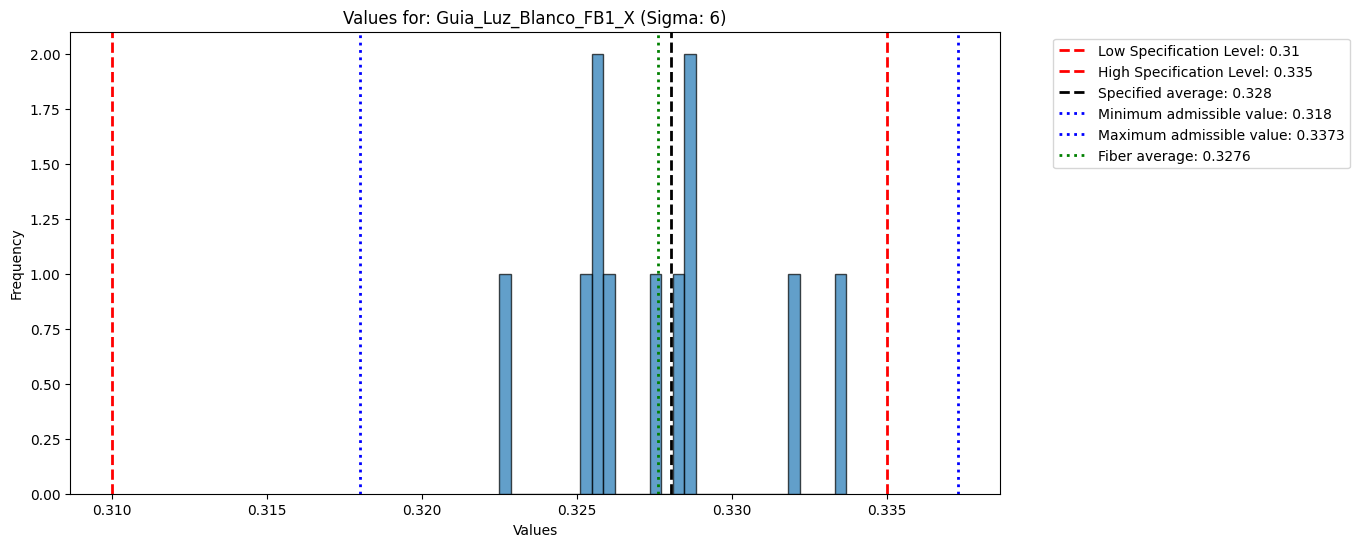

In [7]:
##Visualization of the capability values
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider.value)]
    xrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
_ = plot_capability(MEAS_format, analysis_format, label, sigma_selector.value, xrange=xrange)

In [8]:
##Data export
name_xlsx = glob.tooling + "_capability_analysis_" + get_date() + ".xlsx"
name_pdf = glob.tooling + "_capability_visualization_" + get_date() + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name_xlsx)
    analysis_format.to_excel(output_filepath, index=True, header=True)
    _ = plot_to_pdf(MEAS_format, analysis_format, name_pdf, plot="Capability")
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output
